In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from transformers import pipeline
import apimoex  
import requests
import torch
import moexalgo
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Ваня\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/news.csv')
df.head(5)

,text,date,views,tag_text,href
0,В Польше ситуация с поставкой российского газа...,"1 января 2006, 20:23",31,['В мире'],['/world/']
1,"Цена на газ, предлагаемая Украине, экономическ...","1 января 2006, 19:41",35,[],[]
2,"Газпром: есть данные, что Украина приступила к...","1 января 2006, 19:04",42,['Политика'],['/politics/']
3,Газпром обвинил Украину в несанкционированном ...,"1 января 2006, 18:54",44,['Политика'],['/politics/']
4,"Россия не может забирать туркменский газ, идущ...","1 января 2006, 18:23",39,['Политика'],['/politics/']


Переводим date из df в формат datetime

In [3]:
DEFAULT_DAY = 20
DEFAULT_MONTH = 12
DEFAULT_YEAR = 2025

month_dict = {"января": 1,
              "февраля": 2,
              "марта": 3,
              "апреля": 4,
              "мая": 5,
              "июня": 6,
              "июля": 7,
              "августа": 8,
              "сентября": 9,
              "октября": 10,
              "ноября": 11,
              "декабря": 12}

def date_processing(date_str):
    parts = date_str.split()

    if len(parts) == 1:
        day, month, year = DEFAULT_DAY, DEFAULT_MONTH, DEFAULT_YEAR
        clock = parts[0]

    if len(parts) == 2:
        day, month, year = DEFAULT_DAY - 1, DEFAULT_MONTH, DEFAULT_YEAR
        clock = parts[1]

    if len(parts) == 3:
        day, month, year = parts[0], month_dict[parts[1][:-1]], DEFAULT_YEAR
        clock = parts[2]

    if len(parts) == 4:
        day, month, year = parts[0], month_dict[parts[1]], parts[2][:-1]
        clock = parts[3]

    hour, minute = clock.split(':')

    return datetime(int(year), int(month), int(day), int(hour), int(minute)) 


df['date'] = df['date'].apply(date_processing)
df = df.sort_values(by='date').reset_index(drop=True)

Добавим цены на акции в момент времени, когда вышла новость и через некоторое время после

In [4]:
start_date, end_date = min(df['date']), max(df['date'])

def get_history():
    with requests.Session() as session:
        # Указываем тикер, рынок (shares) и режим торгов (tqbr)
        data = apimoex.get_market_history(
            session, 
            'ROSN', 
            start=start_date, 
            end=end_date,
        )
        prices = pd.DataFrame(data)
        prices['TRADEDATE'] = pd.to_datetime(prices['TRADEDATE'])
        return prices

# Построим график для исключения повторов 
prices = get_history()
presence_map = prices.pivot_table(index='BOARDID', 
                              columns=pd.to_datetime(prices['TRADEDATE']).dt.to_period('W'), 
                              values='CLOSE', # любой числовой столбец
                              aggfunc='count').fillna(0)

presence_map = presence_map.applymap(lambda x: 1 if x > 0 else 0)
plt.figure(figsize=(18, 8))
sns.heatmap(presence_map, cmap="Blues", cbar=False, yticklabels=True)
plt.xlabel('Временная шкала (Недели)')
plt.ylabel('Тикеры')
plt.show()

ConnectionError: HTTPSConnectionPool(host='iss.moex.com', port=443): Max retries exceeded with url: /iss/history/engines/stock/markets/shares/securities/ROSN.json?iss.json=extended&iss.meta=off&from=2006-01-01+02%3A20%3A00&till=2025-12-20+18%3A05%3A00&iss.only=history%2Chistory.cursor&history.columns=BOARDID%2CTRADEDATE%2CCLOSE%2CVOLUME%2CVALUE (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000027C98D2F620>: Failed to resolve 'iss.moex.com' ([Errno 11001] getaddrinfo failed)"))

In [ ]:
eqlv_end = prices[prices['BOARDID'] == 'EQLV']['TRADEDATE'].max()
eqnl_end = prices[prices['BOARDID'] == 'EQNL']['TRADEDATE'].max()
tqbr_start = prices[prices['BOARDID'] == 'TQBR']['TRADEDATE'].min()

part1 = prices[(prices['BOARDID'] == 'EQLV') & (prices['TRADEDATE'] <= eqlv_end)]
part2 = prices[(prices['BOARDID'] == 'EQNL') & (prices['TRADEDATE'] <= eqnl_end)]
part3 = prices[(prices['BOARDID'] == 'SMAL') & (prices['TRADEDATE'] > eqnl_end) & (prices['TRADEDATE'] < tqbr_start)]
part4 = prices[(prices['BOARDID'] == 'TQBR') & (prices['TRADEDATE'] >= tqbr_start)]

final_df = pd.concat([part1, part2, part3, part4]).sort_values('TRADEDATE')
prices = final_df
prices = prices.drop('BOARDID', axis=1)

Делаем сентимент новостей на основе mxlcw/rubert-tiny2-russian-financial-sentiment

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
model = pipeline(model="mxlcw/rubert-tiny2-russian-financial-sentiment", device=device)

results = model(df['text'].tolist())
df['sentiment'] = [res['label'] for res in results]
df['sentiment_score'] = [res['score'] for res in results]

df['day'] = df['date'].dt.date
df_preproc = df.groupby(df['date'].dt.date)['sentiment'].value_counts().unstack(fill_value=0)

Device set to use cpu


KeyboardInterrupt: 

Объединяем сентимент с ценами

In [ ]:
# Посчитано всё в коллабе
df = pd.read_csv('../data/df1.csv')
df['date'] = pd.to_datetime(df['date'])
df_preproc = df.groupby(df['date'].dt.date)['sentiment'].value_counts().unstack(fill_value=0)

df_preproc['views'] = df.groupby(df['date'].dt.date)['views'].aggregate("sum")
df_preproc['number_of_news'] = df_preproc['negative'] + df_preproc['positive'] + df_preproc['neutral']
df_preproc['sentiment_score'] = (df_preproc['positive'] - df_preproc['negative']) / (df_preproc['positive'] + df_preproc['negative'] + 0.25 * df_preproc['neutral'])
df_preproc = df_preproc.reset_index()
df_preproc['date'] = pd.to_datetime(df_preproc['date'])

merged = pd.merge(df_preproc, prices, left_on='date', right_on='TRADEDATE', how='left')

mask = merged['CLOSE'].notna()

groups = mask.iloc[::-1].cumsum().iloc[::-1]
cols_to_fix = ["sentiment_score", "views", "negative", "neutral", "positive", "number_of_news"]
merged[cols_to_fix] = merged.groupby(groups)[cols_to_fix].transform(lambda x: x.mean() if x.name in groups.values else x)

df_final = merged.dropna()
df_final = df_final.drop(['negative', 'neutral', 'positive', 'VALUE', 'TRADEDATE'], axis=1)
df_final = df_final.rename(columns={'CLOSE': 'close', 'VOLUME': 'volume'})

df['year'] = df_final['date'].dt.year
df['day_of_week'] = df_final['date'].dt.day
df['month'] = df_final['date'].dt.month

df_final['rolling_mean_7'] = df['close'].rolling(window=20).mean()
df_final['rolling_mean_14'] = df['close'].rolling(window=20).std()
df_final['rolling_var_7'] = df['close'].rolling(window=20).mean()
df_final['rolling_var_14'] = df['close'].rolling(window=20).std()

df_final.to_csv("../data/data_preprocessed.csv", index=False)

<Axes: >

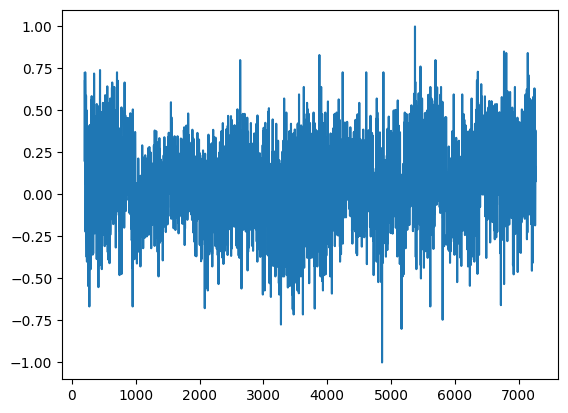

In [12]:
df_final

,date,views,number_of_news,sentiment_score,CLOSE,VOLUME,returns
199,2006-07-19,899,27,0.722222,203.95,517741.0,NaN
200,2006-07-20,501,17,0.551724,203.26,1141288.0,-0.003389
201,2006-07-21,1038,22,0.196721,202.00,1864106.0,-0.006218
204,2006-07-24,553,17,0.680851,201.99,794152.0,-0.000050
205,2006-07-25,756,27,0.388889,202.69,1674834.0,0.003460
...,...,...,...,...,...,...,...
7260,2025-12-15,168207,50,0.186916,409.65,3688415.0,0.018229
7261,2025-12-16,70523,37,0.382979,413.00,3507863.0,0.008144
7262,2025-12-17,129196,47,0.212389,411.45,2995120.0,-0.003760
7263,2025-12-18,152050,50,0.076923,409.25,5504714.0,-0.005361


In [15]:
display(df_final)

,date,views,number_of_news,sentiment_score,CLOSE,VOLUME,returns,day,month,year
199,2006-07-19,899,27,0.722222,203.95,517741.0,NaN,19,7,2006
200,2006-07-20,501,17,0.551724,203.26,1141288.0,-0.003389,20,7,2006
201,2006-07-21,1038,22,0.196721,202.00,1864106.0,-0.006218,21,7,2006
204,2006-07-24,553,17,0.680851,201.99,794152.0,-0.000050,24,7,2006
205,2006-07-25,756,27,0.388889,202.69,1674834.0,0.003460,25,7,2006
...,...,...,...,...,...,...,...,...,...,...
7260,2025-12-15,168207,50,0.186916,409.65,3688415.0,0.018229,15,12,2025
7261,2025-12-16,70523,37,0.382979,413.00,3507863.0,0.008144,16,12,2025
7262,2025-12-17,129196,47,0.212389,411.45,2995120.0,-0.003760,17,12,2025
7263,2025-12-18,152050,50,0.076923,409.25,5504714.0,-0.005361,18,12,2025
